In [1]:
%config Completer.use_jedi = False

In [2]:
from imageio import imread, imsave
import numpy as np
import cv2
import meshplot
from imageio import imread, imsave
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import cv2
import meshplot as mp

# Problem 1

In [7]:
from skimage.color import rgb2gray
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.feature import plot_matches

In [42]:
def sampson_distance(F, x1, x2):
 
    # Compute sampson error for each correspondence.
    Fx1 = np.dot(F, x1)
    Fx2 = np.dot(F, x2)
    denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
    err = ( np.diag(np.dot(x1.T, np.dot(F,x2))) )**2 / denom 

    # return error per point
    return err

def compute_epipole(F):
    """ Computes the (right) epipole from a
    fundamental matrix F.
    (Use with F.T for left epipole.) """
    
    # Fe_1 = 0, thus need to return null space of F (Fx = 0)
    u,s,vh = np.linalg.svd(F)
    e = vh[-1]
    return e

def plot_epipolar_line(im, F, x, epipole=None, show_epipole=True, start=0):
    """ Plot the epipole and epipolar line F*x=0
        in an image. F is the fundamental matrix 
        and x a point in the other image."""
    
    m,n = im.shape[:2]
    line = np.dot(F,x)
    
    # epipolar line parameter and values
    t = np.linspace(start,n,100)
    lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

    # take only line points inside the image
    ndx = (lt>=0) & (lt<m) 
    plt.plot(t[ndx],lt[ndx],linewidth=2)
    
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plt.plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')

def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points
    (x1,x2 3*n arrays) using the normalized 8 point algorithm.
    each row is constructed as
    [x’*x, x’*y, x’, y’*x, y’*y, y’, x, y, 1] """
    
    n = x1.shape[1]
    A = np.zeros([n,9])
    for i in range(n):
        A[i] = np.array([x1[0,i]*x2[0,i], x1[0,i]*x2[1,i], x1[0,i], x1[1,i]*x2[0,i], \
                x1[1,i]*x2[1,i], x1[1,i], x2[0,i], x2[1,i], 1 ])
            
    
    u,s,vh=np.linalg.svd(A.T.dot(A))
    f = vh[-1].reshape(3,3)

    u_f,s_f,vh_f = np.linalg.svd(f)

    s_f[-1]=0
    F = u_f.dot(np.diag(s_f)).dot(vh_f)
    
    return F

def compute_fundamental_normalized(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3xn arrays) using the normalized 8 point algorithm. """

    # normalize image coordinates
    n = x1.shape[1]
    # normalize image coordinates
    mean_x1 = np.mean(x1[:2],axis=1)

    mean_x1_data = np.tile(mean_x1,(n,1)).T

    subs_x1 = x1[:2]-mean_x1_data

    mean_norm_x1 = np.linalg.norm(subs_x1, axis=0, keepdims=False).mean()

    scale_x1 = np.sqrt(2) / mean_norm_x1

    trans_mat_x1 = np.array([[scale_x1,0,-scale_x1*mean_x1[0]],[0,scale_x1,-scale_x1*mean_x1[1]],[0,0,1]])

    x1n = np.dot(trans_mat_x1,x1)

    
    mean_x2 = np.mean(x2[:2],axis=1)

    mean_x2_data = np.tile(mean_x2,(n,1)).T

    subs_x2 = x2[:2]-mean_x2_data

    mean_norm_x2 = np.linalg.norm(subs_x2, axis=0, keepdims=False).mean()

    scale_x2 = np.sqrt(2) / mean_norm_x2

    trans_mat_x2 = np.array([[scale_x2,0,-scale_x2*mean_x2[0]],[0,scale_x2,-scale_x2*mean_x2[1]],[0,0,1]])

    x2n = np.dot(trans_mat_x2,x2)
    # compute F with the normalized coordinates
    F_n = compute_fundamental(x1n, x2n)
    
    F = trans_mat_x1.T.dot(F_n).dot(trans_mat_x2)
    return F

def skew(a):
    """ Skew matrix A such that a x v = Av for any v. """
    return np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])

def make_homog(points):
    return np.vstack((points, np.ones((1, points.shape[1]))))


def triangulate(x1, x2, P1, P2):
    """    
    Two-view triangulation of points in x1,x2 (3xn homog. coordinates). 
    Return: 3xn point cloud
    """
    n = x1.shape[1]
    X = np.zeros([4,n])
    
    for i in range(n):
        mat = np.zeros((6,6))
        mat[:3,:4] = P1
        mat[:3,4] = -x1[:,i]
        mat[3:,:4] = P2
        mat[3:,5] = -x2[:,i]

        u,s,vh = np.linalg.svd(mat.T.dot(mat))
        X[:,i] = vh[-1,:4]
        
    return X

def extract_correspondences(im1, im2, coeff=0.5, num_points=800):
    
    # similar to your panorama implementation, can copy/paste
    im1_g=rgb2gray(im1)
    im2_g=rgb2gray(im2)
    
    orb = ORB(n_keypoints=num_points, fast_threshold=coeff)    
    orb.detect_and_extract(im1_g)
    keypoints1 = orb.keypoints
    descriptors1 = orb.descriptors
   
    orb.detect_and_extract(im2_g)
    keypoints2 = orb.keypoints
    descriptors2 = orb.descriptors
    
    matches_for_plot = match_descriptors(descriptors1,descriptors2,cross_check=True)
    
    pts1 = keypoints1[matches_for_plot[:,0]][:, ::-1]
    pts2 = keypoints2[matches_for_plot[:,1]][:, ::-1]
    kp1= keypoints1
    kp2 = keypoints2

   
    return pts1, pts2, matches_for_plot, kp1, kp2

In [5]:
merton1 = imread("data/merton1.jpg")
merton2 = imread("data/merton2.jpg")

## Problem 1

Text(0.5, 1.0, 'basic matching')

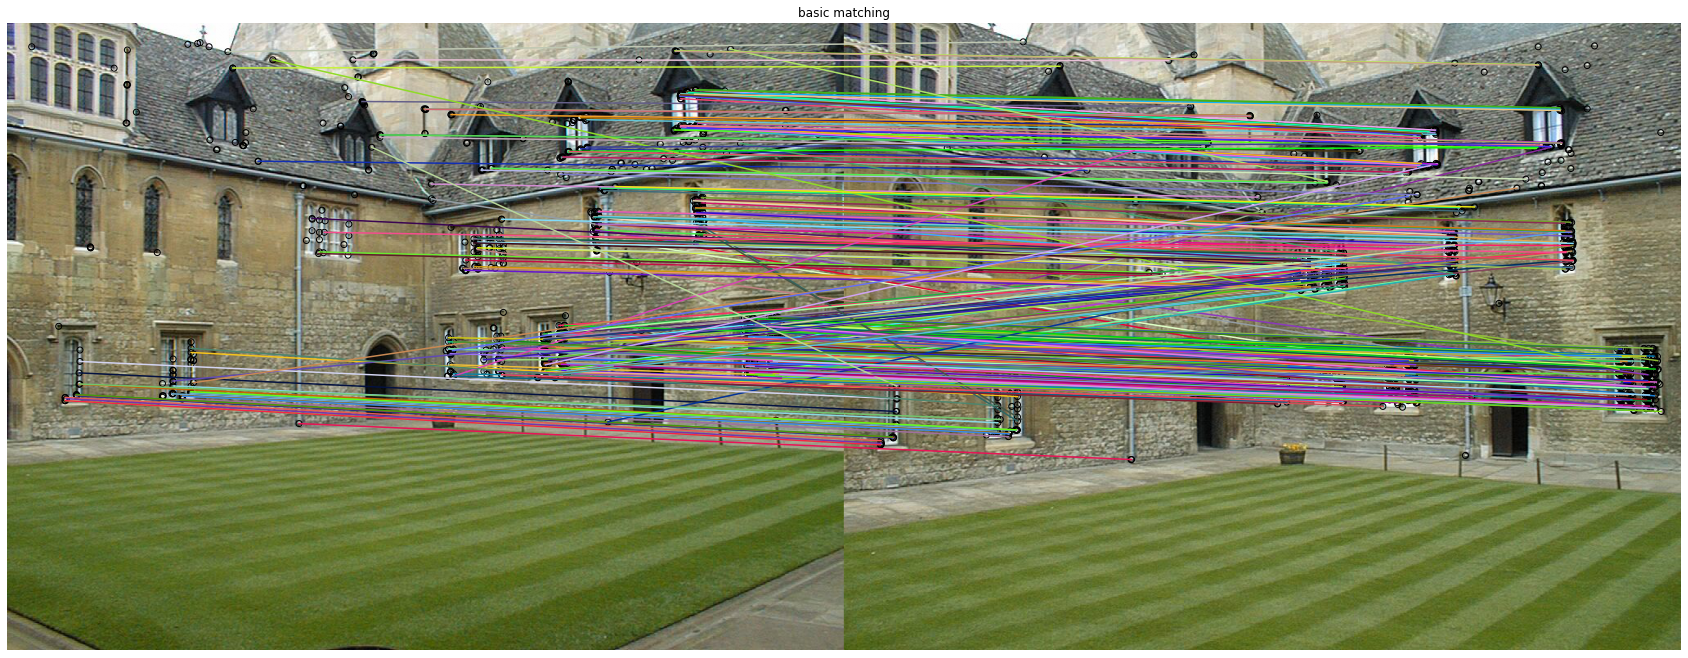

In [14]:
pts1, pts2, matches_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.3)

# Used skimage for last problem sets instead, here to save some time to not rewrite everything to work with cv2 

# img3 = cv2.drawMatchesKnn(merton1,keypoints1, merton2,
#                           keypoints2, matches_for_plot, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# plt.figure(figsize=(20, 10))
# plt.axis('off')
# plt.imshow(img3)
# plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(30,30))


plot_matches(ax, merton1, merton2, kp1, kp2,
             matches_for_plot)
ax.axis("off")
ax.set_title("basic matching")

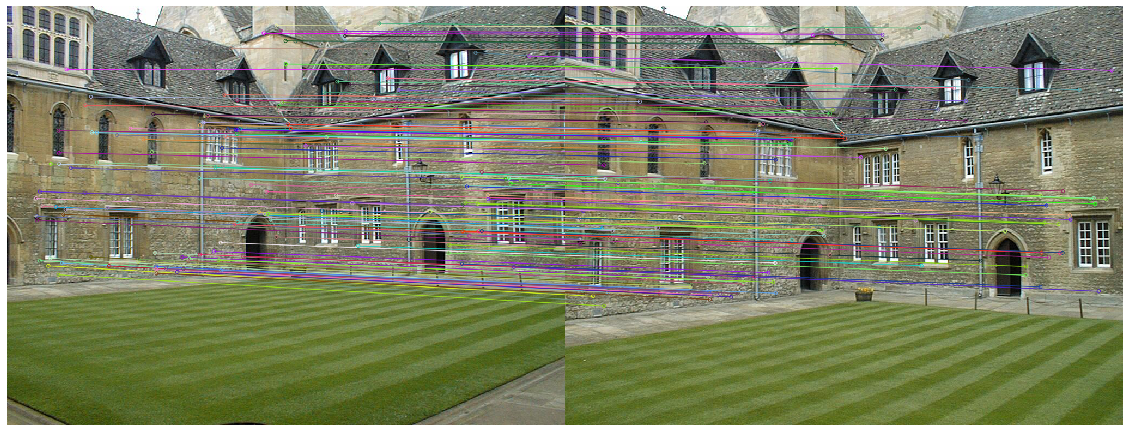

In [4]:
pts1, pts2, matches_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.3)

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(merton1,kp1, merton2,
                          kp2, match_for_plot, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img3)
plt.show()

(3, 341)

In [19]:
# Sampson error

x1 = pts1
x2 = pts2
x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

F = compute_fundamental(x1, x2)

error = sampson_distance(F, make_homog(pts1.T), make_homog(pts2.T))
print(np.median(error))
print("Average Sampson error: {}".format(np.mean(error)))

6230.722369693575
Average Sampson error: 13812.123208409099


In [21]:
# Sampson error

x1 = pts1
x2 = pts2
x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

F = compute_fundamental_normalized(x1, x2)

error = sampson_distance(F, make_homog(pts1.T), make_homog(pts2.T))
print(np.median(error))
print("Average Sampson error: {}".format(np.mean(error)))

544.1151754500219
Average Sampson error: 3015.872154728517


In [33]:
F.shape

(3, 3)

In [35]:
e = compute_epipole(F)

In [36]:
e.shape

(3,)

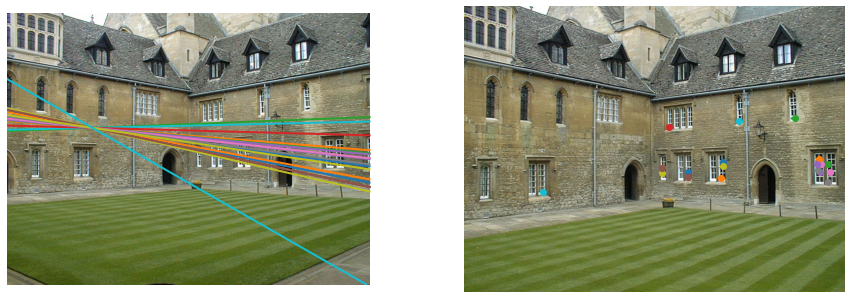

In [37]:
# Epiline plotting

rand_ind = np.random.permutation(pts2.shape[0])

e = compute_epipole(F)

plt.figure(1, figsize=(15,10))
plt.subplot(121)
plt.axis('off')
plt.imshow(merton1)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, False)

plt.subplot(122)
 
plt.axis('off')
plt.imshow(merton2)

for i in range(20):
    plt.plot(x2[0,i],x2[1,i],'o')
    

plt.show()

In [38]:
e.shape

(3,)

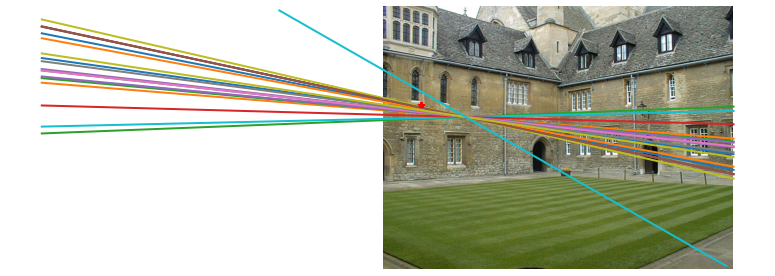

In [41]:
# Epipole plotting

plt.figure(1, figsize=(30,20))

plt.subplot(122)
plt.axis('off')
plt.imshow(merton1)

plt.figure(1, figsize=(15,10))

e = compute_epipole(F)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, True, start=-1000)

    
plt.show()

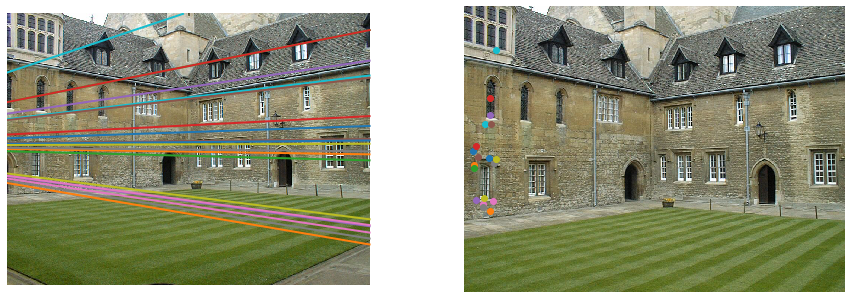

In [7]:
# Epiline plotting

rand_ind = np.random.permutation(pts2.shape[0])

e = compute_epipole(F)

plt.figure(1, figsize=(15,10))
plt.subplot(121)
plt.axis('off')
plt.imshow(merton1)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, False)

plt.subplot(122)
 
plt.axis('off')
plt.imshow(merton2)

for i in range(20):
    plt.plot(x2[0,i],x2[1,i],'o')
    

plt.show()

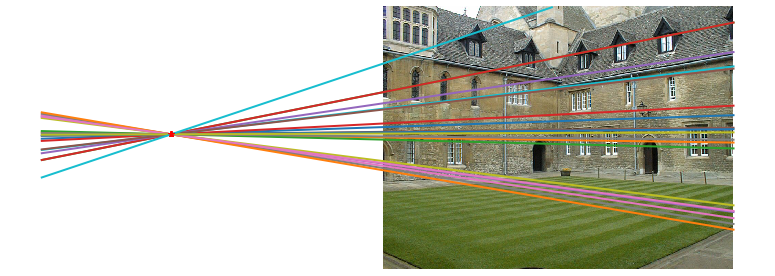

In [8]:
# Epipole plotting

plt.figure(1, figsize=(30,20))

plt.subplot(122)
plt.axis('off')
plt.imshow(merton1)

plt.figure(1, figsize=(15,10))

e = compute_epipole(F.T)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, True, start=-1000)

    
plt.show()

In [45]:
# Triangulation

P1 = np.loadtxt("data/001.P")
P2 = np.loadtxt("data/002.P")

pts1, pts2, match_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.3)

x1 = pts1
x2 = pts2

x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

colors = []

for i in range(pts1.shape[0]):
    u, v = pts1[i,:]
    u = int(u)
    v = int(v)
    colors.append(merton1[v, u,:]/255.)
    
colors = np.array(colors)
points_est = triangulate(x1, x2, P1, P2)[:3,:].T

d = mp.subplot(v=points_est, c=colors, s=[1, 2, 0], shading={"point_size": 0.5})

In [51]:
points_est = triangulate(x1, x2, P1, P2)[:3,:].T

In [55]:
d = mp.subplot(v=points_est, c=colors, s=[1, 2, 0], shading={"point_size": 0.5})

# Problem 2

100%|██████████| 10/10 [02:14<00:00, 13.44s/it]


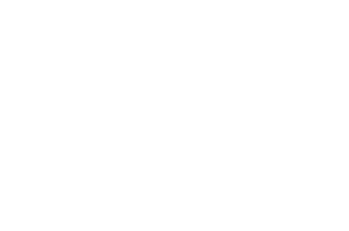

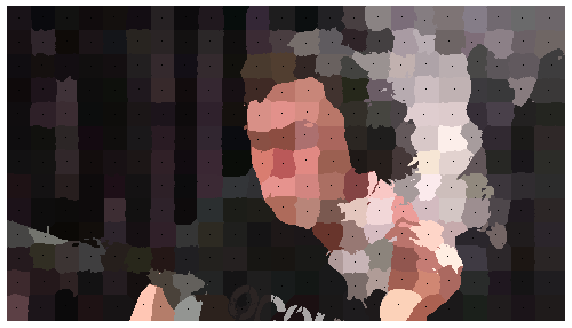

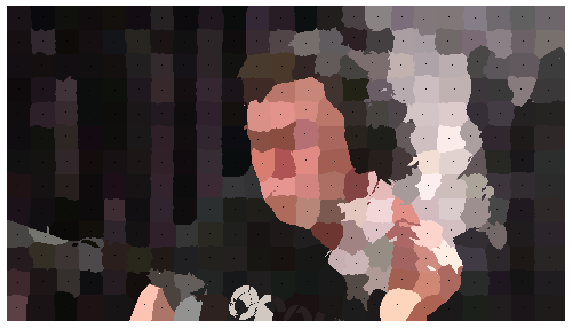

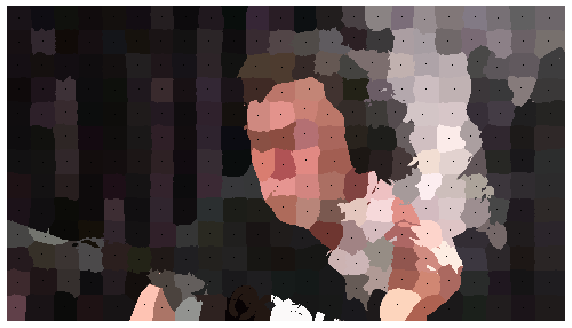

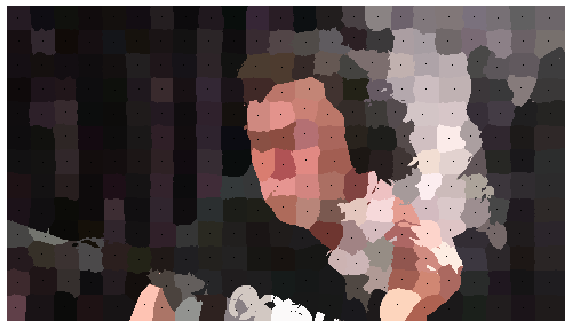

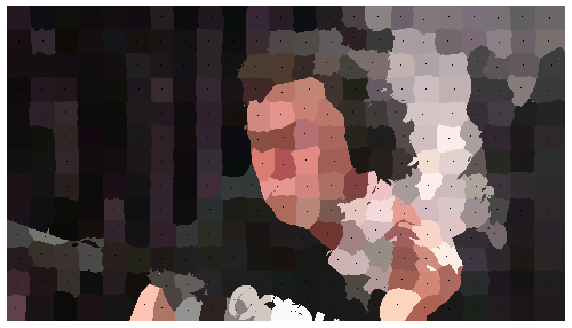

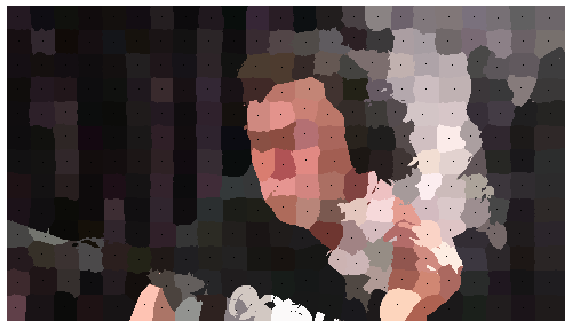

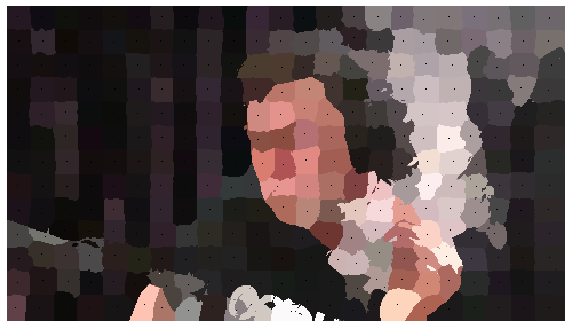

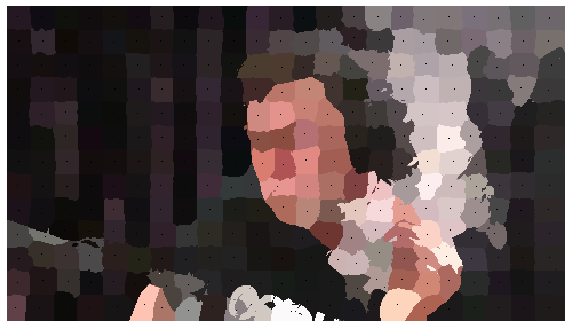

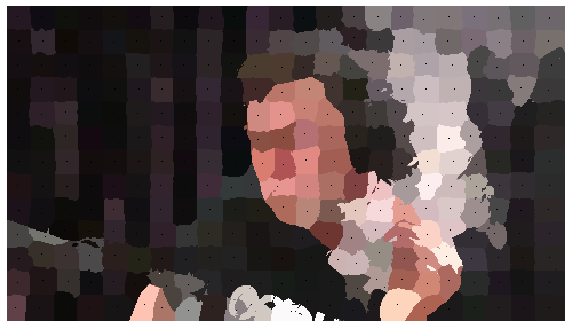

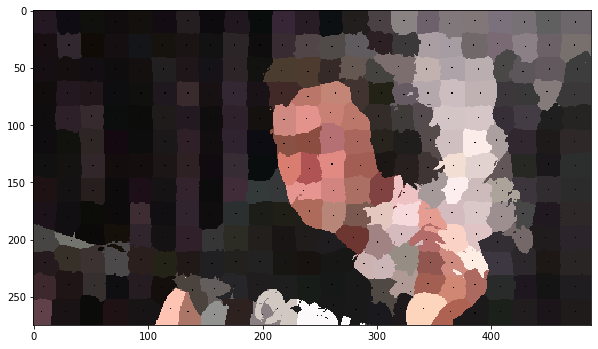

In [10]:
import math
from skimage import io, color
import numpy as np
from tqdm import trange

# note: you can convert to LAB with lab_arr = color.rgb2lab(rgb)

if __name__ == '__main__':
    p = SLIC('data/elon.png', K=300, M=40)
    p.iterate()

